# Lab 8. 실습 코드
# How I improved a class imbalance by increasing iterations in a model
https://python.plainenglish.io/how-i-improved-a-class-imbalance-by-increasing-iterations-in-a-model-6aef2f3befd8

- https://github.com/TracyRenee61/AV-Agriculture (깃허브 코드)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics 
from sklearn.datasets import make_classification
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [3]:
sc=StandardScaler()
mm=MinMaxScaler(feature_range=(0, 2))

In [4]:
#Load datasets
train=pd.read_csv("https://raw.githubusercontent.com/TracyRenee61/AV-Agriculture/master/train_yaOffsB%20-%20train_yaOffsB.csv")
test=pd.read_csv("https://raw.githubusercontent.com/TracyRenee61/AV-Agriculture/master/test_pFkWwen%20-%20test_pFkWwen.csv")
sample_sub=pd.read_csv("https://raw.githubusercontent.com/TracyRenee61/AV-Agriculture/master/sample_submission_O1oDc4H%20-%20sample_submission_O1oDc4H.csv")

In [5]:
train.head()
train.shape
test.shape

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


(88858, 10)

(59310, 9)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  int64  
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  int64  
 6   Number_Weeks_Used        79858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  int64  
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


0    0.84
1    0.14
2    0.03
Name: Crop_Damage, dtype: float64

<AxesSubplot:>

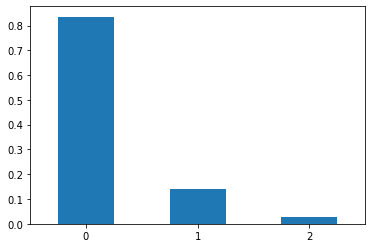

In [7]:
train['Crop_Damage'].value_counts(normalize=True).round(2)
train['Crop_Damage'].value_counts(normalize=True).plot(rot='360', kind='bar')

In [8]:
train.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,79858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.391881,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [9]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [10]:
test.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [11]:
# fill up missing values with median
train['Number_Weeks_Used'] = train['Number_Weeks_Used'].fillna(train['Number_Weeks_Used'].median())
test['Number_Weeks_Used'] = test['Number_Weeks_Used'].fillna(test['Number_Weeks_Used'].median())

In [12]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

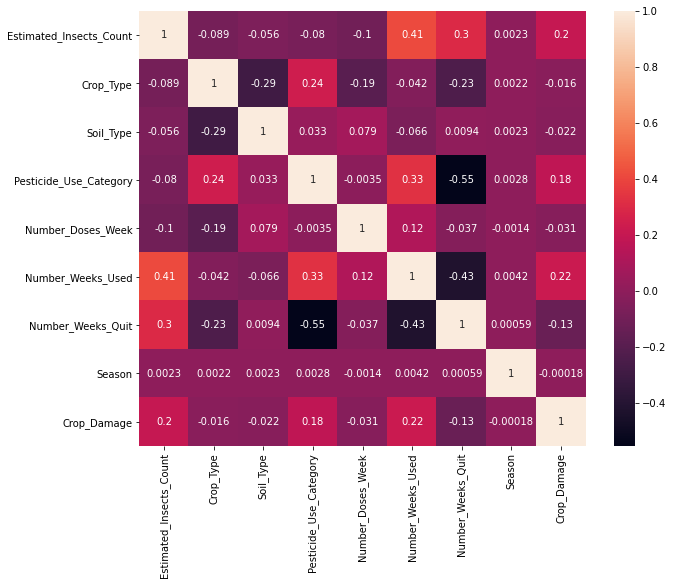

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=True)

In [14]:
damage = train.groupby(by=("Crop_Damage")).sum().reset_index()
damage

,Crop_Damage,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,0,97675485,21460,34397,165520,1939040,2035257.0,750594,140847
1,1,22633880,3103,5354,29741,297535,417472.0,93911,23310
2,2,4004062,706,983,5930,60400,85124.0,7642,4403


<AxesSubplot:xlabel='Crop_Damage', ylabel='Density'>

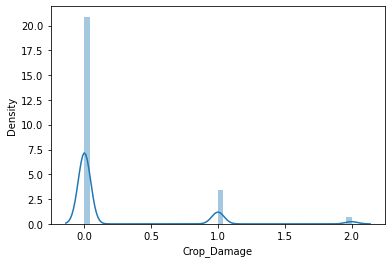

In [15]:
sns.distplot(train['Crop_Damage'])

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Insect Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Insect Frequency'}, ylabel='Estimated_Insects_Count'>

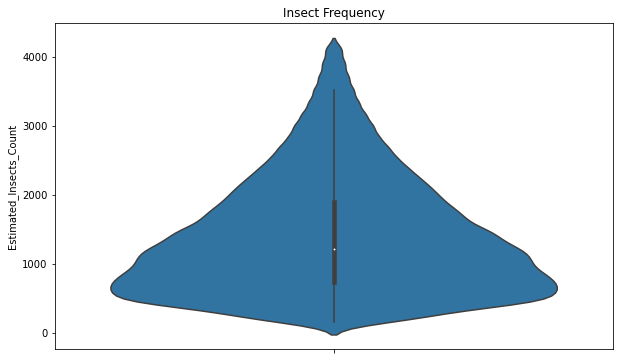

In [16]:
plt.figure(figsize=(10,6))
plt.title("Insect Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Estimated_Insects_Count"])
plt.show()

<AxesSubplot:xlabel='Estimated_Insects_Count', ylabel='Crop_Damage'>

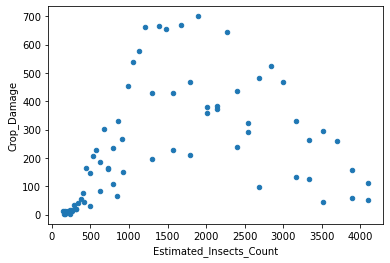

In [17]:
insect = train.groupby(by=("Estimated_Insects_Count"))["Crop_Damage"].sum().reset_index()
insect.plot.scatter(x='Estimated_Insects_Count', y = 'Crop_Damage')

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Crop Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Crop Frequency'}, ylabel='Crop_Type'>

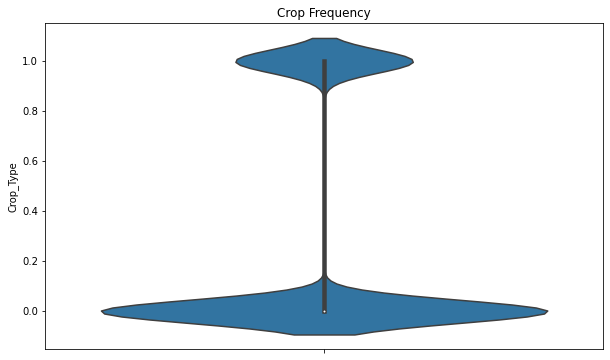

In [18]:
plt.figure(figsize=(10,6))
plt.title("Crop Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Crop_Type"])
plt.show()

In [19]:
crop = train.groupby(by=("Crop_Type"))["Crop_Damage"].sum().reset_index()
crop

,Crop_Type,Crop_Damage
0,0,12418
1,1,4515


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Soil Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Soil Frequency'}, ylabel='Soil_Type'>

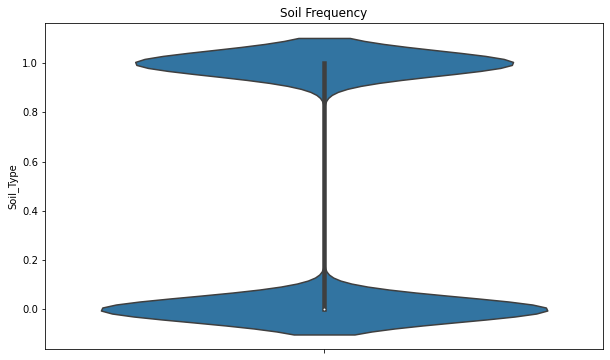

In [20]:
plt.figure(figsize=(10,6))
plt.title("Soil Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Soil_Type"])
plt.show()

In [21]:
soil = train.groupby(by=("Soil_Type"))["Crop_Damage"].sum().reset_index()
soil

,Soil_Type,Crop_Damage
0,0,9613
1,1,7320


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Pesticide Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Pesticide Frequency'}, ylabel='Pesticide_Use_Category'>

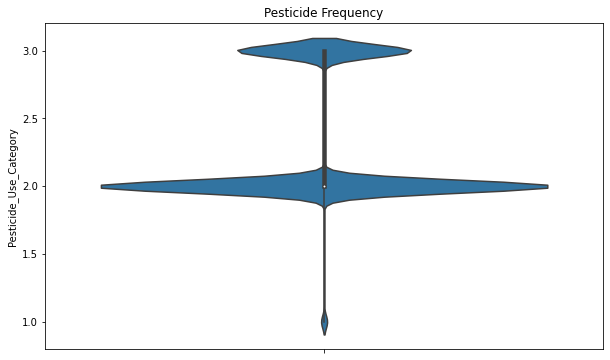

In [22]:
plt.figure(figsize=(10,6))
plt.title("Pesticide Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Pesticide_Use_Category"])
plt.show()

In [23]:
pest = train.groupby(by=("Pesticide_Use_Category"))["Crop_Damage"].sum().reset_index()
pest

,Pesticide_Use_Category,Crop_Damage
0,1,884
1,2,7430
2,3,8619


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Dosage Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Dosage Frequency'}, ylabel='Number_Doses_Week'>

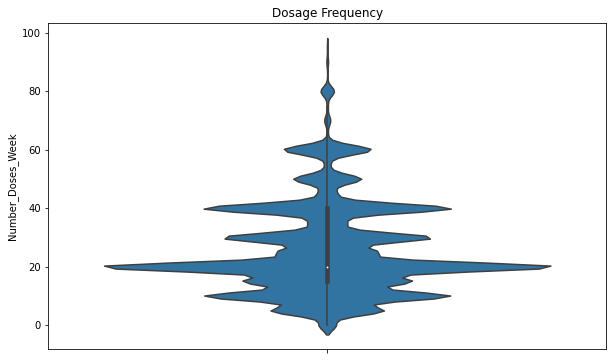

In [24]:
plt.figure(figsize=(10,6))
plt.title("Dosage Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Number_Doses_Week"])
plt.show()

<AxesSubplot:xlabel='Number_Doses_Week', ylabel='Crop_Damage'>

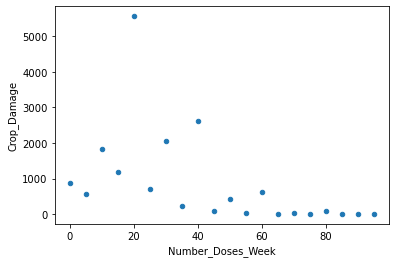

In [25]:
dose = train.groupby(by=("Number_Doses_Week"))["Crop_Damage"].sum().reset_index()
dose.plot.scatter(x='Number_Doses_Week', y = 'Crop_Damage')

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Usage Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Usage Frequency'}, ylabel='Number_Weeks_Used'>

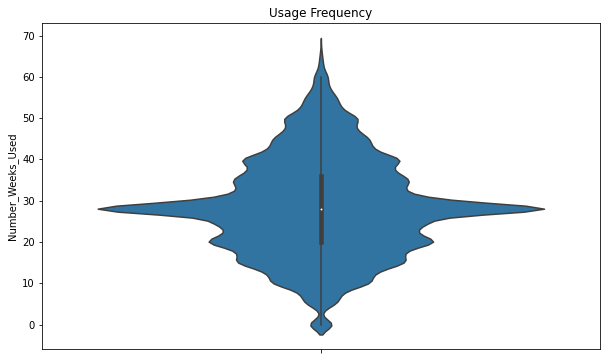

In [26]:
plt.figure(figsize=(10,6))
plt.title("Usage Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Number_Weeks_Used"])
plt.show()

In [27]:
train.Number_Weeks_Used=train.Number_Weeks_Used.astype(int)
test.Number_Weeks_Used=test.Number_Weeks_Used.astype(int)

<AxesSubplot:xlabel='Number_Weeks_Used', ylabel='Crop_Damage'>

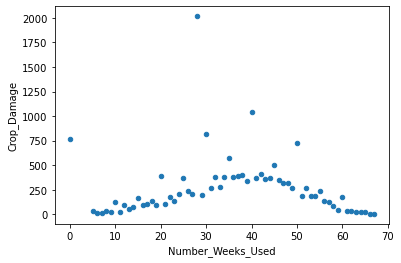

In [28]:
week = train.groupby(by=("Number_Weeks_Used"))["Crop_Damage"].sum().reset_index()
week.plot.scatter(x='Number_Weeks_Used', y = 'Crop_Damage')

In [29]:
train.Number_Weeks_Used=train.Number_Weeks_Used.astype(int)
test.Number_Weeks_Used=test.Number_Weeks_Used.astype(int)

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Quit Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Quit Frequency'}, ylabel='Number_Weeks_Quit'>

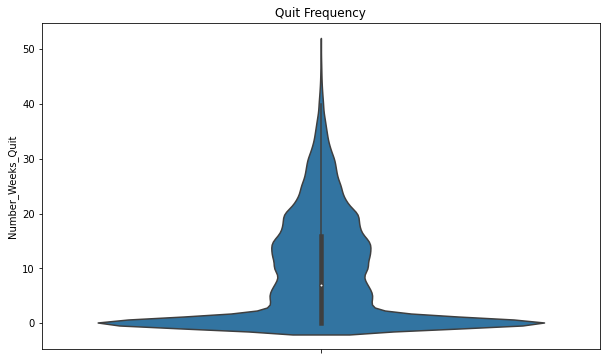

In [30]:
plt.figure(figsize=(10,6))
plt.title("Quit Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Number_Weeks_Quit"])
plt.show()

<AxesSubplot:xlabel='Number_Weeks_Quit', ylabel='Crop_Damage'>

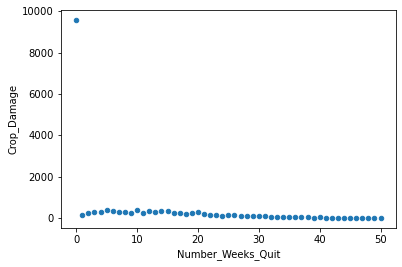

In [31]:
quit = train.groupby(by=("Number_Weeks_Quit"))["Crop_Damage"].sum().reset_index()
quit.plot.scatter(x='Number_Weeks_Quit', y = 'Crop_Damage')

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Season Frequency')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

<AxesSubplot:title={'center':'Season Frequency'}, ylabel='Season'>

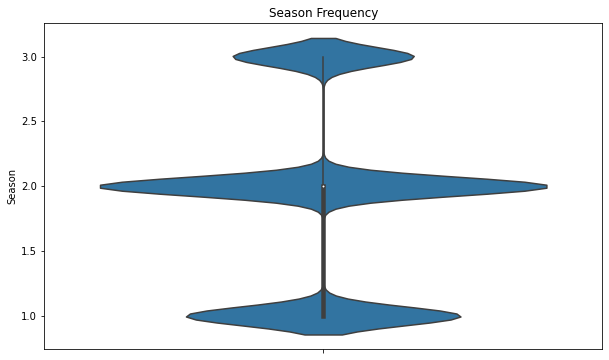

In [32]:
plt.figure(figsize=(10,6))
plt.title("Season Frequency")
sns.axes_style("dark")
sns.violinplot(y=train["Season"])
plt.show()

In [33]:
season = train.groupby(by=("Season"))["Crop_Damage"].sum().reset_index()
season

,Season,Crop_Damage
0,1,5070
1,2,8543
2,3,3320


In [34]:
#set up features
features=['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week',
          'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']

train_labels = np.array(train.Crop_Damage.values.reshape(-1, 1), dtype=np.float32)

In [35]:
#define x, y and x_test
X=train[features]
y=train_labels
X_test=test[features]

In [36]:
#scale x, y and x_test
X=mm.fit_transform(X)
y=mm.fit_transform(y)
X_test=mm.fit_transform(X_test)

In [37]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

In [38]:
#split training set for training and testing
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled, random_state=1, test_size=0.15)

In [39]:
#check shapes of testing data
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((189306, 8), (33408, 8), (189306,), (33408,))

In [40]:
# random forest
rfc = RandomForestClassifier(n_estimators=10).fit(train_X, train_y)
# predict on test set
rfc_pred = rfc.predict(val_X)
# scoring
accuracy_score(val_y, rfc_pred), f1_score(val_y, rfc_pred, average='weighted'), recall_score(val_y, rfc_pred, average='weighted')

(0.8634159482758621, 0.8631266987551061, 0.8634159482758621)

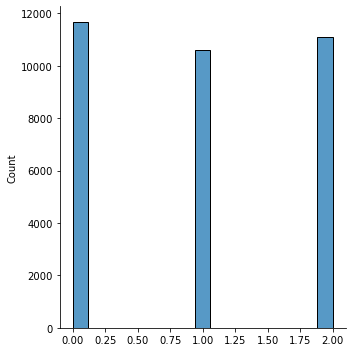

In [41]:
sns.displot(rfc_pred)

In [42]:
from collections import Counter
Counter(val_y)
Counter(rfc_pred)

Counter({1.0: 10966, 2.0: 11144, 0.0: 11298})

Counter({0.0: 11681, 2.0: 11109, 1.0: 10618})

In [43]:
#print the tunable parameters (They were not tuned in this example, everything kept as default)
params = rfc.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [44]:
#Create a confusion matrix
#y_test as first argument and the preds as second argument 
confusion_matrix(val_y, rfc_pred)

array([[10036,   983,   279],
       [ 1347,  8799,   820],
       [  298,   836, 10010]], dtype=int64)

In [45]:
#transform confusion matrix into array
#the matrix is stored in a vaiable called confmtrx
confmtrx = np.array(confusion_matrix(val_y, rfc_pred))
#Create DataFrame from confmtrx array 
#rows for test: Male, Female, Infant designation as index 
#columns for preds: male, predicted_female, predicted_infant as column
pd.DataFrame(confmtrx, index=['Alive','Other_Causes', 'Pesticides'],
columns=['predicted_Alive', 'predicted_Other_Causes', 'predicted_Pesticides'])

,predicted_Alive,predicted_Other_Causes,predicted_Pesticides
Alive,10036,983,279
Other_Causes,1347,8799,820
Pesticides,298,836,10010


In [46]:
#Accuracy statistics
print('Accuracy Score:', metrics.accuracy_score(val_y, rfc_pred))  
#Create classification report
class_report=classification_report(val_y, rfc_pred)
print(class_report)

Accuracy Score: 0.8634159482758621
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87     11298
         1.0       0.83      0.80      0.82     10966
         2.0       0.90      0.90      0.90     11144

    accuracy                           0.86     33408
   macro avg       0.86      0.86      0.86     33408
weighted avg       0.86      0.86      0.86     33408



In [47]:
y_pred=rfc.predict(val_X)

val_y=val_y.flatten()
y_pred=y_pred.flatten()

df=pd.DataFrame({'Actual': val_y, 'Predicted':y_pred})
df

,Actual,Predicted
0,1.0,0.0
1,2.0,2.0
2,2.0,2.0
3,1.0,1.0
4,2.0,2.0
...,...,...
33403,0.0,0.0
33404,2.0,2.0
33405,1.0,1.0
33406,0.0,0.0


In [48]:
import os
os.makedirs('../data', exist_ok=True)
os.makedirs('../output', exist_ok=True)
os.makedirs('../image', exist_ok=True)
os.makedirs('../working', exist_ok=True)
df.to_csv('../working/submission.csv', index=False)

# End